In [ ]:
%pip install git+https://github.com/metadriverse/metadrive.git
!pip install stable-baselines3  # For PPO experiments
!pip install gym  # Ensure gym is installed


  Cloning https://github.com/metadriverse/metadrive.git to /tmp/pip-req-build-mahpbj4a
  Running command git clone --filter=blob:none --quiet https://github.com/metadriverse/metadrive.git /tmp/pip-req-build-mahpbj4a
  Resolved https://github.com/metadriverse/metadrive.git to commit b908149e422f2e7715207ca1eb81380342de5681
  Preparing metadata (setup.py) ... done


In [ ]:
!apt-get install -y xvfb python-opengl ffmpeg

!pip install pyvirtualdisplay

!sudo apt-get update
!sudo apt-get install -y xvfb


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package python-opengl
Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,624 kB]
Get:12 https://r2u.stat.illinois.edu/ubun

In [ ]:
import os
import numpy as np
from stable_baselines3 import PPO
from metadrive.envs import MetaDriveEnv
from pyvirtualdisplay import Display
from PIL import Image
from IPython.display import display as ipy_display, clear_output
from stable_baselines3.common.monitor import Monitor
import matplotlib.pyplot as plt
from stable_baselines3.common.callbacks import BaseCallback


/usr/local/lib/python3.10/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.cloud')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-pa

In [ ]:
class PerformanceLogger(BaseCallback):
    def __init__(self, verbose=0):
        super(PerformanceLogger, self).__init__(verbose)
        self.timesteps = []
        self.rewards = []
        self.current_reward = 0

    def reset(self):
        """Reset the logger for a new training phase."""
        self.current_reward = 0


    def _on_step(self) -> bool:
        # Sum rewards from this step
        self.current_reward += sum(self.locals["rewards"])

        # Log rewards at the end of a rollout
        if self.n_calls % self.model.n_steps == 0:
            self.timesteps.append(self.num_timesteps)
            self.rewards.append(self.current_reward / self.model.n_steps)  # Average reward per step
            self.current_reward = 0  # Reset for next rollout
        return True


In [ ]:
# Function to create the environment
def create_environment(difficulty, render=False):
    configs = {
        "easy": {"map": 3, "traffic_density": 0.1, "random_lane_width": False, "use_render": render},
        "medium": {"map": 5, "traffic_density": 0.3, "random_lane_width": True, "use_render": render},
        "hard": {"map": 7, "traffic_density": 0.5, "random_lane_width": True, "use_render": render},
    }
    base_env = MetaDriveEnv(configs[difficulty])
    return Monitor(base_env)

In [ ]:
def train_agent_with_transfer(env, timesteps=1000, model=None):
    logger = PerformanceLogger()
    if model is None:
        model = PPO("MlpPolicy", env, verbose=2, n_steps=32) #changing n_step param significantly changes reward results, should play ard with this
    else:
        print("Continuing training with transfer learning...")
    logger.reset()  # Reset logger for the new training phase
    model.learn(total_timesteps=timesteps, callback=logger)
    return model, logger

In [ ]:
def plot_performance(logger, title= 'Agent Performance'):
    """
    Plot the logged performance data.
    """
    if not logger.timesteps or not logger.rewards:
        print("[ERROR] No data to plot. Ensure rewards are logged during training.")
        return

    plt.figure(figsize=(12, 6))
    plt.plot(logger.timesteps, logger.rewards, label="Episode Rewards")
    plt.xlabel("Timesteps")
    plt.ylabel("Rewards")
    plt.title("Agent Performance Over Timesteps")
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
# Curriculum experiment without transfer learning
def curriculum_experiment_no_transfer(difficulty_order, timesteps_per_difficulty=10000):
    results = []
    for difficulty in difficulty_order:
        print(f"Training on {difficulty} difficulty (No Transfer)...")
        env = create_environment(difficulty, render=False)
        try:
            model, logger = train_agent_with_transfer(env, timesteps=timesteps_per_difficulty)
            results.append((difficulty, logger))
        finally:
            env.close()

    # Plot performance for each difficulty
    for difficulty, logger in results:
        print(f"Performance for {difficulty} difficulty:")
        plot_performance(logger, f"Performance on {difficulty} (No Transfer)")

In [ ]:
# Curriculum experiment with transfer learning
def curriculum_experiment_with_transfer(difficulty_order, timesteps_per_difficulty=1000):
    model = None  # Start with no pretrained model
    logger = PerformanceLogger()
    results = []

    for difficulty in difficulty_order:
        print(f"Training on {difficulty} difficulty (With Transfer)...")
        env = create_environment(difficulty, render=False)
        try:
            model, logger = train_agent_with_transfer(env, model=model, timesteps=timesteps_per_difficulty)
            results.append((difficulty, logger))
        finally:
            env.close()

    # Plot performance for each difficulty
    for difficulty, logger in results:
        print(f"Performance for {difficulty} difficulty:")
        plot_performance(logger, f"Performance on {difficulty} (With Transfer)")

[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): None
/usr/local/lib/python3.10/dist-packages/stable_baselines3/ppo/ppo.py:155: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 32`, after every 0 untruncated mini-batches, there will be a truncated mini-batch of size 32
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=32 and n_envs=1)
  warnings.warn(
[INFO] Assets version: 0.4.3
[INFO] Known Pipes: glxGraphicsPipe
[INFO] Start Scenario Index: 0, Num Scenarios : 1


Running Curriculum Experiment WITHOUT Transfer Learning...
Training on easy difficulty (No Transfer)...
Using cpu device
Wrapping the env in a DummyVecEnv.
---------------------------
| time/              |    |
|    fps             | 57 |
|    iterations      | 1  |
|    time_elapsed    | 0  |
|    total_timesteps | 32 |
---------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 81          |
|    iterations           | 2           |
|    time_elapsed         | 0           |
|    total_timesteps      | 64          |
| train/                  |             |
|    approx_kl            | 0.010453537 |
|    clip_fraction        | 0.0406      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.84       |
|    explained_variance   | -0.349      |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0163     |
|    n_updates            | 10          |
|    policy_gradie

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 183         |
|    ep_rew_mean          | -0.652      |
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 6           |
|    time_elapsed         | 1           |
|    total_timesteps      | 192         |
| train/                  |             |
|    approx_kl            | 0.019282563 |
|    clip_fraction        | 0.0969      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.84       |
|    explained_variance   | 0.0645      |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0582     |
|    n_updates            | 50          |
|    policy_gradient_loss | -0.0371     |
|    std                  | 1           |
|    value_loss           | 0.0171      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 124          |
|    ep_rew_mean          | -0.887       |
| time/                   |              |
|    fps                  | 109          |
|    iterations           | 8            |
|    time_elapsed         | 2            |
|    total_timesteps      | 256          |
| train/                  |              |
|    approx_kl            | 0.0035177618 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.84        |
|    explained_variance   | -0.0246      |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00377      |
|    n_updates            | 70           |
|    policy_gradient_loss | -0.00695     |
|    std                  | 0.999        |
|    value_loss           | 0.2          |
------------------------------------------
------------------------------------------
| rollout/ 

[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): None
[INFO] Assets version: 0.4.3
[INFO] Known Pipes: glxGraphicsPipe
[INFO] Start Scenario Index: 0, Num Scenarios : 1


Training on medium difficulty (No Transfer)...
Using cpu device
Wrapping the env in a DummyVecEnv.
---------------------------
| time/              |    |
|    fps             | 18 |
|    iterations      | 1  |
|    time_elapsed    | 1  |
|    total_timesteps | 32 |
---------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 29           |
|    iterations           | 2            |
|    time_elapsed         | 2            |
|    total_timesteps      | 64           |
| train/                  |              |
|    approx_kl            | 0.0046309046 |
|    clip_fraction        | 0.00625      |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.84        |
|    explained_variance   | -0.0442      |
|    learning_rate        | 0.0003       |
|    loss                 | -0.0206      |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.0131      |
|    std         

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 287         |
|    ep_rew_mean          | 15.9        |
| time/                   |             |
|    fps                  | 30          |
|    iterations           | 9           |
|    time_elapsed         | 9           |
|    total_timesteps      | 288         |
| train/                  |             |
|    approx_kl            | 0.008989999 |
|    clip_fraction        | 0.0344      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.81       |
|    explained_variance   | 0.0364      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.901       |
|    n_updates            | 80          |
|    policy_gradient_loss | -0.0285     |
|    std                  | 0.988       |
|    value_loss           | 3.34        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 152          |
|    ep_rew_mean          | 6.18         |
| time/                   |              |
|    fps                  | 30           |
|    iterations           | 10           |
|    time_elapsed         | 10           |
|    total_timesteps      | 320          |
| train/                  |              |
|    approx_kl            | 0.0030365176 |
|    clip_fraction        | 0.00313      |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.81        |
|    explained_variance   | 0.0102       |
|    learning_rate        | 0.0003       |
|    loss                 | 5.54         |
|    n_updates            | 90           |
|    policy_gradient_loss | -0.00557     |
|    std                  | 0.987        |
|    value_loss           | 12.1         |
------------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 86.2          |
|    ep_rew_mean          | 1.02          |
| time/                   |               |
|    fps                  | 30            |
|    iterations           | 11            |
|    time_elapsed         | 11            |
|    total_timesteps      | 352           |
| train/                  |               |
|    approx_kl            | 0.00017503276 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -2.81         |
|    explained_variance   | -0.000657     |
|    learning_rate        | 0.0003        |
|    loss                 | 4.22          |
|    n_updates            | 100           |
|    policy_gradient_loss | 0.00207       |
|    std                  | 0.987         |
|    value_loss           | 10.4          |
-------------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 74           |
|    ep_rew_mean          | 0.33         |
| time/                   |              |
|    fps                  | 31           |
|    iterations           | 12           |
|    time_elapsed         | 12           |
|    total_timesteps      | 384          |
| train/                  |              |
|    approx_kl            | 0.0007420182 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.81        |
|    explained_variance   | -0.000705    |
|    learning_rate        | 0.0003       |
|    loss                 | 3.49         |
|    n_updates            | 110          |
|    policy_gradient_loss | 4.66e-05     |
|    std                  | 0.987        |
|    value_loss           | 10.5         |
------------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 64.5         |
|    ep_rew_mean          | -0.283       |
| time/                   |              |
|    fps                  | 31           |
|    iterations           | 13           |
|    time_elapsed         | 13           |
|    total_timesteps      | 416          |
| train/                  |              |
|    approx_kl            | 0.0047552325 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.81        |
|    explained_variance   | -0.000854    |
|    learning_rate        | 0.0003       |
|    loss                 | 1.51         |
|    n_updates            | 120          |
|    policy_gradient_loss | -0.00999     |
|    std                  | 0.986        |
|    value_loss           | 3.13         |
------------------------------------------
-----------------------------------------
| rollout/  

[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): None
[INFO] Assets version: 0.4.3
[INFO] Known Pipes: glxGraphicsPipe
[INFO] Start Scenario Index: 0, Num Scenarios : 1


Training on hard difficulty (No Transfer)...
Using cpu device
Wrapping the env in a DummyVecEnv.
---------------------------
| time/              |    |
|    fps             | 7  |
|    iterations      | 1  |
|    time_elapsed    | 4  |
|    total_timesteps | 32 |
---------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 11          |
|    iterations           | 2           |
|    time_elapsed         | 5           |
|    total_timesteps      | 64          |
| train/                  |             |
|    approx_kl            | 0.013143236 |
|    clip_fraction        | 0.0594      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.84       |
|    explained_variance   | 0.00127     |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0189     |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0154     |
|    std                  | 0.997  

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 270         |
|    ep_rew_mean          | 4.94        |
| time/                   |             |
|    fps                  | 16          |
|    iterations           | 9           |
|    time_elapsed         | 17          |
|    total_timesteps      | 288         |
| train/                  |             |
|    approx_kl            | 0.003612196 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.83       |
|    explained_variance   | 0.126       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00622     |
|    n_updates            | 80          |
|    policy_gradient_loss | -0.00603    |
|    std                  | 0.995       |
|    value_loss           | 0.0609      |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 145        |
|    ep_rew_mean          | 0.539      |
| time/                   |            |
|    fps                  | 16         |
|    iterations           | 10         |
|    time_elapsed         | 19         |
|    total_timesteps      | 320        |
| train/                  |            |
|    approx_kl            | 0.00754386 |
|    clip_fraction        | 0.0406     |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.83      |
|    explained_variance   | -0.00926   |
|    learning_rate        | 0.0003     |
|    loss                 | 4.17       |
|    n_updates            | 90         |
|    policy_gradient_loss | -0.00244   |
|    std                  | 0.994      |
|    value_loss           | 9.77       |
----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 131         |
|    ep_rew_mean          | 0.733       |
| time/                   |             |
|    fps                  | 17          |
|    iterations           | 13          |
|    time_elapsed         | 23          |
|    total_timesteps      | 416         |
| train/                  |             |
|    approx_kl            | 0.004684441 |
|    clip_fraction        | 0.00937     |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.83       |
|    explained_variance   | 0.0317      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0639      |
|    n_updates            | 120         |
|    policy_gradient_loss | -0.00925    |
|    std                  | 0.994       |
|    value_loss           | 0.42        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 104         |
|    ep_rew_mean          | -0.331      |
| time/                   |             |
|    fps                  | 17          |
|    iterations           | 14          |
|    time_elapsed         | 25          |
|    total_timesteps      | 448         |
| train/                  |             |
|    approx_kl            | 0.006032113 |
|    clip_fraction        | 0.0187      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.83       |
|    explained_variance   | 0.00459     |
|    learning_rate        | 0.0003      |
|    loss                 | 4.04        |
|    n_updates            | 130         |
|    policy_gradient_loss | -0.00229    |
|    std                  | 0.994       |
|    value_loss           | 8.51        |
-----------------------------------------
-----------------------------------------
| rollout/                |       

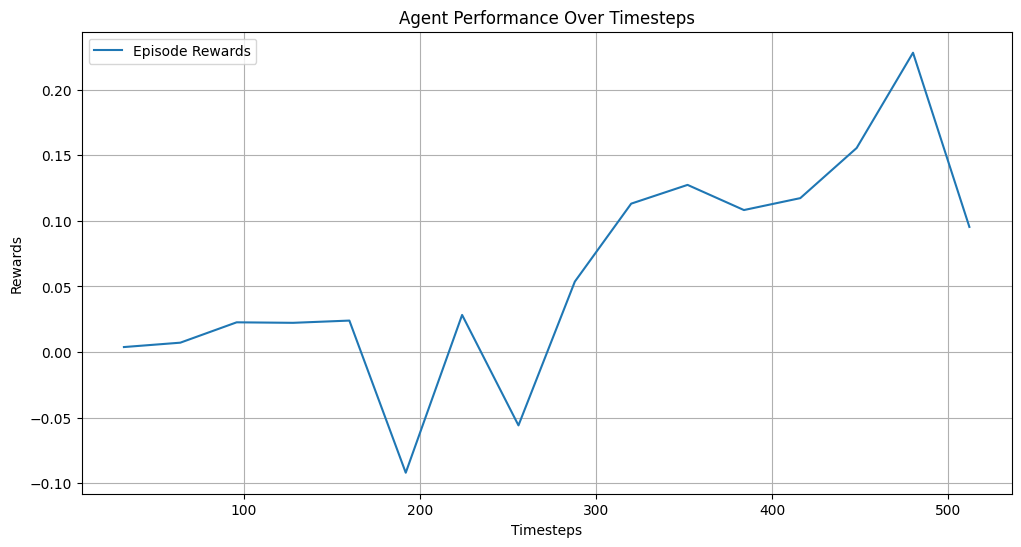

Performance for medium difficulty:


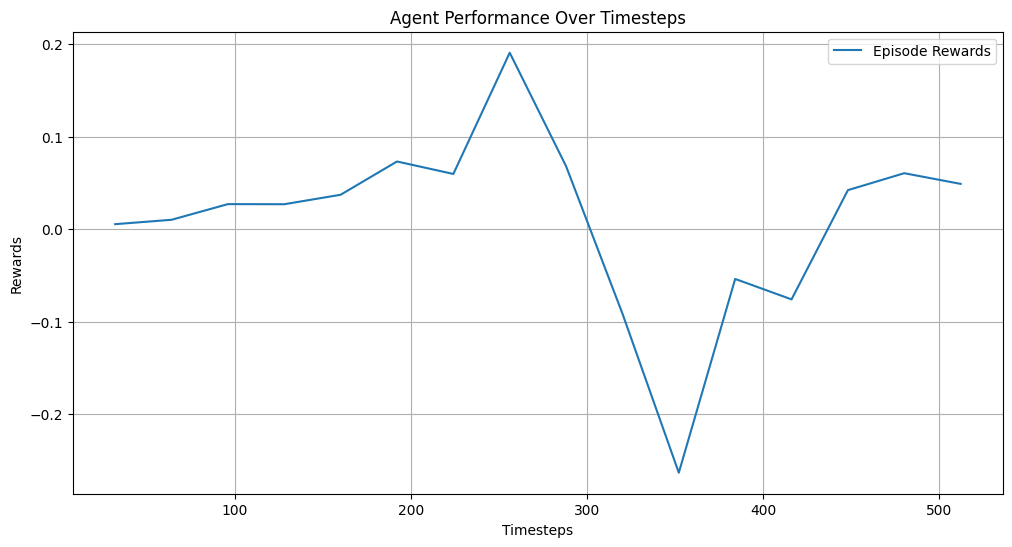

Performance for hard difficulty:


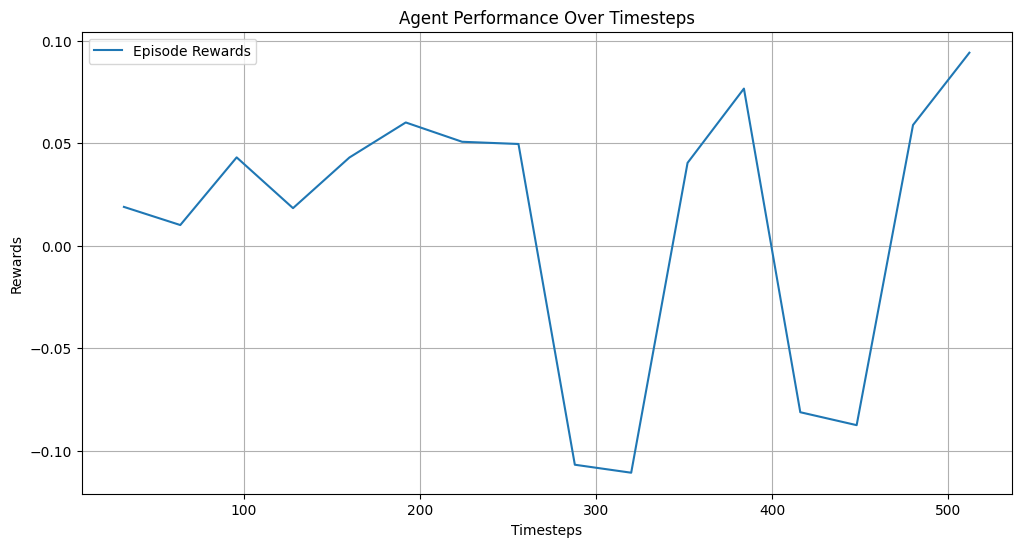

[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): None
[INFO] Assets version: 0.4.3
[INFO] Known Pipes: glxGraphicsPipe
[INFO] Start Scenario Index: 0, Num Scenarios : 1


Running Curriculum Experiment WITH Transfer Learning...
Training on easy difficulty (With Transfer)...
Using cpu device
Wrapping the env in a DummyVecEnv.
---------------------------
| time/              |    |
|    fps             | 36 |
|    iterations      | 1  |
|    time_elapsed    | 0  |
|    total_timesteps | 32 |
---------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 53          |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_timesteps      | 64          |
| train/                  |             |
|    approx_kl            | 0.012847021 |
|    clip_fraction        | 0.0469      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.84       |
|    explained_variance   | 0.00855     |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0404     |
|    n_updates            | 10          |
|    policy_gradien

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 314         |
|    ep_rew_mean          | 12          |
| time/                   |             |
|    fps                  | 68          |
|    iterations           | 10          |
|    time_elapsed         | 4           |
|    total_timesteps      | 320         |
| train/                  |             |
|    approx_kl            | 0.010508247 |
|    clip_fraction        | 0.0406      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.82       |
|    explained_variance   | 0.0102      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.021       |
|    n_updates            | 90          |
|    policy_gradient_loss | -0.017      |
|    std                  | 0.99        |
|    value_loss           | 0.361       |
-----------------------------------------
------------------------------------------
| rollout/                |      

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 184        |
|    ep_rew_mean          | 6.13       |
| time/                   |            |
|    fps                  | 72         |
|    iterations           | 12         |
|    time_elapsed         | 5          |
|    total_timesteps      | 384        |
| train/                  |            |
|    approx_kl            | 0.00731257 |
|    clip_fraction        | 0.025      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.81      |
|    explained_variance   | 0.00477    |
|    learning_rate        | 0.0003     |
|    loss                 | 0.447      |
|    n_updates            | 110        |
|    policy_gradient_loss | -0.0217    |
|    std                  | 0.988      |
|    value_loss           | 1.23       |
----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 147         |
|    ep_rew_mean          | 7.07        |
| time/                   |             |
|    fps                  | 74          |
|    iterations           | 14          |
|    time_elapsed         | 6           |
|    total_timesteps      | 448         |
| train/                  |             |
|    approx_kl            | 0.002184419 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.81       |
|    explained_variance   | 0.0317      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.846       |
|    n_updates            | 130         |
|    policy_gradient_loss | -0.00883    |
|    std                  | 0.987       |
|    value_loss           | 2.02        |
-----------------------------------------
------------------------------------------
| rollout/                |      

[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): None
[INFO] Assets version: 0.4.3
[INFO] Known Pipes: glxGraphicsPipe
[INFO] Start Scenario Index: 0, Num Scenarios : 1


Training on medium difficulty (With Transfer)...
Continuing training with transfer learning...
---------------------------
| time/              |    |
|    fps             | 57 |
|    iterations      | 1  |
|    time_elapsed    | 0  |
|    total_timesteps | 32 |
---------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 73          |
|    iterations           | 2           |
|    time_elapsed         | 0           |
|    total_timesteps      | 64          |
| train/                  |             |
|    approx_kl            | 0.002035657 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.81       |
|    explained_variance   | 2.5e-05     |
|    learning_rate        | 0.0003      |
|    loss                 | 0.154       |
|    n_updates            | 170         |
|    policy_gradient_loss | -0.00452    |
|    std                  | 0.988    

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 84           |
|    ep_rew_mean          | 6.25         |
| time/                   |              |
|    fps                  | 71           |
|    iterations           | 3            |
|    time_elapsed         | 1            |
|    total_timesteps      | 96           |
| train/                  |              |
|    approx_kl            | 0.0053495467 |
|    clip_fraction        | 0.00313      |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.81        |
|    explained_variance   | 0.0214       |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0822       |
|    n_updates            | 180          |
|    policy_gradient_loss | -0.00449     |
|    std                  | 0.988        |
|    value_loss           | 0.497        |
------------------------------------------
------------------------------------------
| rollout/ 

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 118           |
|    ep_rew_mean          | 20.4          |
| time/                   |               |
|    fps                  | 78            |
|    iterations           | 8             |
|    time_elapsed         | 3             |
|    total_timesteps      | 256           |
| train/                  |               |
|    approx_kl            | 0.00028000027 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -2.82         |
|    explained_variance   | 0.00102       |
|    learning_rate        | 0.0003        |
|    loss                 | 3.15          |
|    n_updates            | 230           |
|    policy_gradient_loss | -0.00107      |
|    std                  | 0.989         |
|    value_loss           | 7.53          |
-------------------------------------------
--------------------------------

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 101           |
|    ep_rew_mean          | 16            |
| time/                   |               |
|    fps                  | 80            |
|    iterations           | 10            |
|    time_elapsed         | 3             |
|    total_timesteps      | 320           |
| train/                  |               |
|    approx_kl            | 0.00067159534 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -2.81         |
|    explained_variance   | -0.00708      |
|    learning_rate        | 0.0003        |
|    loss                 | 1.75          |
|    n_updates            | 250           |
|    policy_gradient_loss | -0.00439      |
|    std                  | 0.988         |
|    value_loss           | 3.73          |
-------------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 85.2         |
|    ep_rew_mean          | 12.2         |
| time/                   |              |
|    fps                  | 81           |
|    iterations           | 11           |
|    time_elapsed         | 4            |
|    total_timesteps      | 352          |
| train/                  |              |
|    approx_kl            | 0.0003118962 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.81        |
|    explained_variance   | -0.000377    |
|    learning_rate        | 0.0003       |
|    loss                 | 11.3         |
|    n_updates            | 260          |
|    policy_gradient_loss | 0.00183      |
|    std                  | 0.988        |
|    value_loss           | 22.8         |
------------------------------------------
------------------------------------------
| rollout/ 

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 88.8         |
|    ep_rew_mean          | 13.1         |
| time/                   |              |
|    fps                  | 82           |
|    iterations           | 14           |
|    time_elapsed         | 5            |
|    total_timesteps      | 448          |
| train/                  |              |
|    approx_kl            | 0.0005405564 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.81        |
|    explained_variance   | -0.00107     |
|    learning_rate        | 0.0003       |
|    loss                 | 1.08         |
|    n_updates            | 290          |
|    policy_gradient_loss | -0.000777    |
|    std                  | 0.988        |
|    value_loss           | 2.53         |
------------------------------------------
------------------------------------------
| rollout/ 

[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): None
[INFO] Assets version: 0.4.3
[INFO] Known Pipes: glxGraphicsPipe
[INFO] Start Scenario Index: 0, Num Scenarios : 1


Training on hard difficulty (With Transfer)...
Continuing training with transfer learning...
---------------------------
| time/              |    |
|    fps             | 37 |
|    iterations      | 1  |
|    time_elapsed    | 0  |
|    total_timesteps | 32 |
---------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 43            |
|    iterations           | 2             |
|    time_elapsed         | 1             |
|    total_timesteps      | 64            |
| train/                  |               |
|    approx_kl            | 0.00019575655 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -2.81         |
|    explained_variance   | 0.000231      |
|    learning_rate        | 0.0003        |
|    loss                 | 0.412         |
|    n_updates            | 330           |
|    policy_gradient_loss | 0.000233      |
|    st

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | 19.1         |
| time/                   |              |
|    fps                  | 44           |
|    iterations           | 4            |
|    time_elapsed         | 2            |
|    total_timesteps      | 128          |
| train/                  |              |
|    approx_kl            | 0.0009974055 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.81        |
|    explained_variance   | 4.77e-06     |
|    learning_rate        | 0.0003       |
|    loss                 | 0.97         |
|    n_updates            | 350          |
|    policy_gradient_loss | 0.000613     |
|    std                  | 0.987        |
|    value_loss           | 2.37         |
------------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 73            |
|    ep_rew_mean          | 8.06          |
| time/                   |               |
|    fps                  | 47            |
|    iterations           | 5             |
|    time_elapsed         | 3             |
|    total_timesteps      | 160           |
| train/                  |               |
|    approx_kl            | 0.00018686242 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -2.81         |
|    explained_variance   | 0.000223      |
|    learning_rate        | 0.0003        |
|    loss                 | 17.4          |
|    n_updates            | 360           |
|    policy_gradient_loss | -4.38e-05     |
|    std                  | 0.987         |
|    value_loss           | 35            |
-------------------------------------------
--------------------------------

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 68.7        |
|    ep_rew_mean          | 6.29        |
| time/                   |             |
|    fps                  | 55          |
|    iterations           | 7           |
|    time_elapsed         | 4           |
|    total_timesteps      | 224         |
| train/                  |             |
|    approx_kl            | 0.005921159 |
|    clip_fraction        | 0.00937     |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.81       |
|    explained_variance   | 0.00271     |
|    learning_rate        | 0.0003      |
|    loss                 | 0.169       |
|    n_updates            | 380         |
|    policy_gradient_loss | -0.0108     |
|    std                  | 0.986       |
|    value_loss           | 0.4         |
-----------------------------------------
------------------------------------------
| rollout/                |      

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 55.2         |
|    ep_rew_mean          | 4.33         |
| time/                   |              |
|    fps                  | 59           |
|    iterations           | 9            |
|    time_elapsed         | 4            |
|    total_timesteps      | 288          |
| train/                  |              |
|    approx_kl            | 0.0014359243 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.81        |
|    explained_variance   | -0.00181     |
|    learning_rate        | 0.0003       |
|    loss                 | 1.71         |
|    n_updates            | 400          |
|    policy_gradient_loss | -0.000242    |
|    std                  | 0.985        |
|    value_loss           | 3.51         |
------------------------------------------
------------------------------------------
| rollout/ 

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 53.7         |
|    ep_rew_mean          | 3.99         |
| time/                   |              |
|    fps                  | 64           |
|    iterations           | 11           |
|    time_elapsed         | 5            |
|    total_timesteps      | 352          |
| train/                  |              |
|    approx_kl            | 0.0024813171 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.81        |
|    explained_variance   | -0.000795    |
|    learning_rate        | 0.0003       |
|    loss                 | 0.841        |
|    n_updates            | 420          |
|    policy_gradient_loss | -0.00617     |
|    std                  | 0.985        |
|    value_loss           | 1.78         |
------------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 54.4       |
|    ep_rew_mean          | 3.95       |
| time/                   |            |
|    fps                  | 65         |
|    iterations           | 12         |
|    time_elapsed         | 5          |
|    total_timesteps      | 384        |
| train/                  |            |
|    approx_kl            | 0.03379611 |
|    clip_fraction        | 0.188      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.81      |
|    explained_variance   | -6.15e-05  |
|    learning_rate        | 0.0003     |
|    loss                 | 4.41       |
|    n_updates            | 430        |
|    policy_gradient_loss | -0.0271    |
|    std                  | 0.984      |
|    value_loss           | 8.91       |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_me

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 52.1        |
|    ep_rew_mean          | 3.34        |
| time/                   |             |
|    fps                  | 69          |
|    iterations           | 14          |
|    time_elapsed         | 6           |
|    total_timesteps      | 448         |
| train/                  |             |
|    approx_kl            | 0.012187945 |
|    clip_fraction        | 0.0312      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.81       |
|    explained_variance   | 0.00154     |
|    learning_rate        | 0.0003      |
|    loss                 | 0.244       |
|    n_updates            | 450         |
|    policy_gradient_loss | -0.0178     |
|    std                  | 0.984       |
|    value_loss           | 0.571       |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 52          |
|    ep_rew_mean          | 3.17        |
| time/                   |             |
|    fps                  | 70          |
|    iterations           | 15          |
|    time_elapsed         | 6           |
|    total_timesteps      | 480         |
| train/                  |             |
|    approx_kl            | 0.018289577 |
|    clip_fraction        | 0.0969      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.81       |
|    explained_variance   | 0.00016     |
|    learning_rate        | 0.0003      |
|    loss                 | 2.49        |
|    n_updates            | 460         |
|    policy_gradient_loss | -0.0066     |
|    std                  | 0.985       |
|    value_loss           | 5.06        |
-----------------------------------------
-----------------------------------------
| rollout/                |       

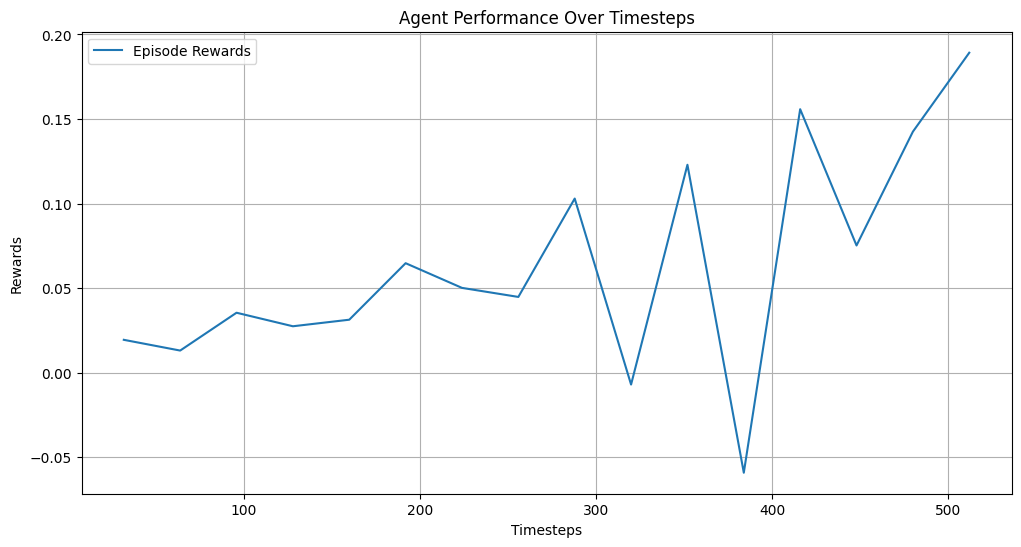

Performance for medium difficulty:


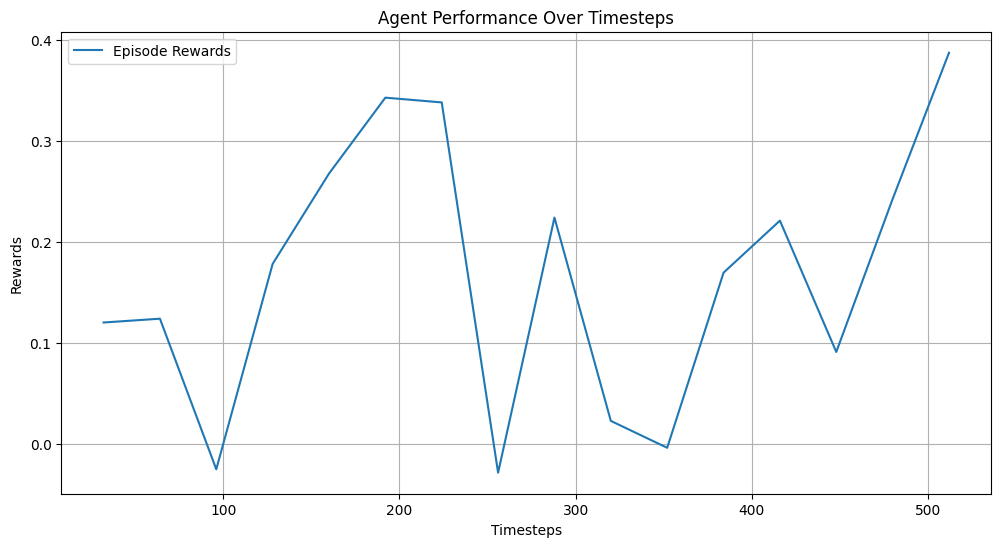

Performance for hard difficulty:


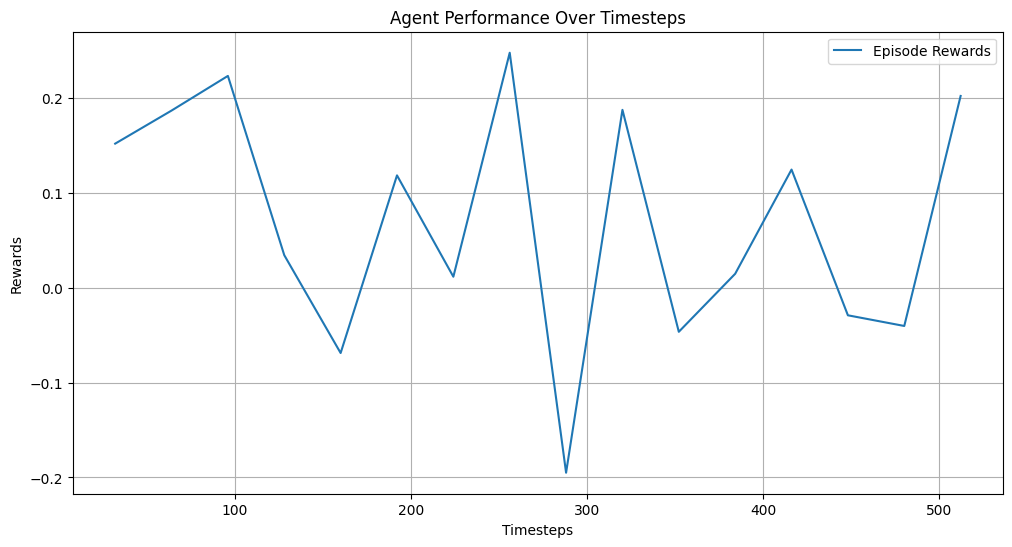

In [ ]:
# Run the curriculum experiments
difficulty_order = ["easy", "medium", "hard"]

# Experiment without transfer learning
print("Running Curriculum Experiment WITHOUT Transfer Learning...")
curriculum_experiment_no_transfer(difficulty_order, timesteps_per_difficulty=500)

# Experiment with transfer learning
print("Running Curriculum Experiment WITH Transfer Learning...")
curriculum_experiment_with_transfer(difficulty_order, timesteps_per_difficulty=500)

# Code for simulator, not tested

In [ ]:
from pyvirtualdisplay import Display

# Set up the virtual display
display = Display(visible=0, size=(972, 729))
display.start()

In [ ]:
def show_frame(env, step, interval=10):
    if step % interval == 0:  # Show every 'interval' steps
        base_env = env.unwrapped  # Access the underlying MetaDriveEnv
        frame = base_env.render(mode="rgb_array")
        if frame is None:
            print("[WARNING] Frame rendering failed. Ensure 'use_render=True' in the configuration.")
            return
        img = Image.fromarray(frame)
        clear_output(wait=True)
        display(img)

In [ ]:
def reset_environment(env, difficulty):
    base_env = env.unwrapped
    if difficulty == "easy":
        base_env.config.update({"map": 3, "traffic_density": 0.1, "random_lane_width": False, "use_render": False})
    elif difficulty == "medium":
        base_env.config.update({"map": 5, "traffic_density": 0.3, "random_lane_width": True, "use_render": False})
    elif difficulty == "hard":
        base_env.config.update({"map": 7, "traffic_density": 0.5, "random_lane_width": True, "use_render": False})
    base_env.reset()


In [ ]:
def evaluate_model_with_visualization(model, env, num_episodes=5):
  rewards = []
  for episode in range(num_episodes):
      obs, _ = env.reset()
      done = False
      total_reward = 0
      step = 0
      while not done:
          action, _ = model.predict(obs, deterministic=True)
          obs, reward, done, truncated, info = env.step(action)
          total_reward += reward
          show_frame(env, step)  # Display the frame every few steps
          step += 1
      rewards.append(total_reward)
  return rewards

SyntaxError: incomplete input (<ipython-input-14-59946a11ebd1>, line 1)

In [ ]:
def evaluate_and_save_video(model, env, num_episodes=1, output_dir="./video"):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    frames = []

    for episode in range(num_episodes):
        obs, _ = env.reset()
        done = False
        total_reward = 0
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, done, truncated, info = env.step(action)
            total_reward += reward
            frame = env.unwrapped.render(mode="rgb_array")
            if frame is not None:
                frames.append(Image.fromarray(frame))
        print(f"Episode {episode + 1} finished with total reward: {total_reward}")

    # Save video as GIF
    video_path = os.path.join(output_dir, "evaluation.gif")
    frames[0].save(
        video_path,
        save_all=True,
        append_images=frames[1:],
        duration=50,  # Duration of each frame in milliseconds
        loop=0,
    )
    print(f"Video saved at: {video_path}")

In [ ]:
def curriculum_experiment_reuse_env(order):
    """
    Runs a curriculum learning experiment using a single reusable environment.
    """
    results = []
    env = create_environment("easy", render=True)  # Use a single environment

    for difficulty in order:
        print(f"Training on {difficulty} difficulty...")
        reset_environment(env, difficulty)
        model = train_agent(env, timesteps=100)
        evaluate_and_save_video(model, env, num_episodes=1)  # Save video for 1 episode
        results.append((difficulty, [0]))  # Placeholder for rewards in quick test

    env.close()
    return results

In [ ]:
def summarize_results(results):
    """
    Summarizes the results of the experiment.
    """
    for difficulty, rewards in results:
        avg_reward = np.mean(rewards)
        std_reward = np.std(rewards)
        print(f"Difficulty: {difficulty}, Avg Reward: {avg_reward:.2f}, Std Dev: {std_reward:.2f}")

results = curriculum_experiment_reuse_env(["easy", "medium", "hard"])
summarize_results(results)

[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector(), main_camera: MainCamera(1200, 900), dashboard: DashBoard()]
[INFO] Render Mode: onscreen
[INFO] Horizon (Max steps per agent): None
[INFO] Assets version: 0.4.3


Training on easy difficulty...


[INFO] Known Pipes: glxGraphicsPipe
[WARNING] Since your screen is too small (1080, 810), we resize the window to (972, 729). (engine_core.py:230)
[INFO] Start Scenario Index: 0, Num Scenarios : 1
